(ppd)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`面板数据的Pandas使用 <single: Pandas for Panel Data>`

```{index} single: Python; Pandas
```

```{contents} 目录
:depth: 2
```

## 概述

在[之前关于pandas的讲座](https://python-programming.quantecon.org/pandas.html)中，我们学习了如何处理简单的数据集。

计量经济学家经常需要处理更复杂的数据集，比如面板数据。

常见任务包括：

* 导入数据、清理数据以及在多个轴上重塑数据。

* 从面板数据中选择时间序列或横截面数据。
* 对数据进行分组和汇总。

`pandas`（源自'panel'和'data'）包含强大且易用的工具，专门用于解决这类问题。

在接下来的内容中，我们将使用来自OECD的实际最低工资面板数据集来创建：

* 数据多个维度的汇总统计
* 数据集中各国平均最低工资的时间序列
* 按大洲划分的工资核密度估计

我们将首先从CSV文件中读取长格式面板数据，并使用`pivot_table`重塑生成的`DataFrame`来构建`MultiIndex`。

使用pandas的`merge`函数将为我们的`DataFrame`添加额外的详细信息，并使用`groupby`函数对数据进行汇总。

## 切片和重塑数据

我们将读取来自OECD的32个国家的实际最低工资数据集，并将其赋值给`realwage`。

数据集可通过以下链接访问：

In [1]:
url1 = 'https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/realwage.csv'

In [2]:
import pandas as pd

# 为了查看目的显示6列
pd.set_option('display.max_columns', 6)

# 将小数点位数减少到2位
pd.options.display.float_format = '{:,.2f}'.format

realwage = pd.read_csv(url1)

让我们看看我们有什么可以使用的数据

In [3]:
realwage.head()  # 显示前5行

,Unnamed: 0,Time,Country,Series,Pay period,value
0,0,2006-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,132.44"
1,1,2007-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,100.92"
2,2,2008-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,747.41"
3,3,2009-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,580.14"
4,4,2010-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,755.83"


数据目前是长格式的，当数据有多个维度时这种格式难以分析。

我们将使用`pivot_table`创建宽格式面板，并使用`MultiIndex`来处理高维数据。

`pivot_table`的参数需要指定数据（values）、索引和我们想要在结果数据框中的列。

通过在columns参数中传入一个列表，我们可以在列轴上创建一个`MultiIndex`

In [4]:
realwage = realwage.pivot_table(values='value',
                                index='Time',
                                columns=['Country', 'Series', 'Pay period'])
realwage.head()

Country                                   Australia         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                20,410.65  10.33   
2007-01-01                                21,087.57  10.67   
2008-01-01                                20,718.24  10.48   
2009-01-01                                20,984.77  10.62   
2010-01-01                                20,879.33  10.57   

Country                                                        ...  \
Series     In 2015 constant prices at 2015 USD exchange rates  ...   
Pay period                                             Annual  ...   
Time                                                           ...   
2006-01-01                                          23,826.64  ...   
2007-01-01                                          24,616.84  ...   
2008-01-01                                          24,185.70  ...   
2009-01-01                                          24,496.84  ...   
2010-01-01                                          24,373.76  ...   

Country                               United States  \
Series     In 2015 constant prices at 2015 USD PPPs   
Pay period                                   Hourly   
Time                                                  
2006-01-01                                     6.05   
2007-01-01                                     6.24   
2008-01-01                                     6.78   
2009-01-01                                     7.58   
2010-01-01                                     7.88   

Country                                                               
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88  

[5 rows x 128 columns]

为了更容易地过滤我们的时间序列数据，接下来我们将把索引转换为`DateTimeIndex`

In [5]:
realwage.index = pd.to_datetime(realwage.index)
type(realwage.index)

pandas.core.indexes.datetimes.DatetimeIndex

这些列包含多层级索引，称为`MultiIndex`，各层级按层次结构排序（国家 > 系列 > 支付周期）。

`MultiIndex`是在pandas中管理面板数据最简单和最灵活的方式。

In [6]:
type(realwage.columns)

pandas.core.indexes.multi.MultiIndex

In [7]:
realwage.columns.names

FrozenList(['Country', 'Series', 'Pay period'])

和之前一样，我们可以选择国家（我们的`MultiIndex`的最高层级）

In [8]:
realwage['United States'].head()

Series     In 2015 constant prices at 2015 USD PPPs         \
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                12,594.40   6.05   
2007-01-01                                12,974.40   6.24   
2008-01-01                                14,097.56   6.78   
2009-01-01                                15,756.42   7.58   
2010-01-01                                16,391.31   7.88   

Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88

在本讲中，我们将经常使用`MultiIndex`的堆叠和取消堆叠来将数据框重塑成所需的格式。

`.stack()`将列`MultiIndex`的最低层级旋转到行索引（`.unstack()`的作用方向相反 - 你可以试试看）

In [9]:
realwage.stack().head()

/tmp/ipykernel_7572/743219372.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  realwage.stack().head()


Country                                              Australia  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    20,410.65   
           Hourly                                        10.33   
2007-01-01 Annual                                    21,087.57   
           Hourly                                        10.67   
2008-01-01 Annual                                    20,718.24   

Country                                                                   \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              23,826.64   
           Hourly                                                  12.06   
2007-01-01 Annual                                              24,616.84   
           Hourly                                                  12.46   
2008-01-01 Annual                                              24,185.70   

Country                                                Belgium  ...  \
Series                In 2015 constant prices at 2015 USD PPPs  ...   
Time       Pay period                                           ...   
2006-01-01 Annual                                    21,042.28  ...   
           Hourly                                        10.09  ...   
2007-01-01 Annual                                    21,310.05  ...   
           Hourly                                        10.22  ...   
2008-01-01 Annual                                    21,416.96  ...   

Country                                                   United Kingdom  \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              20,376.32   
           Hourly                                                   9.81   
2007-01-01 Annual                                              20,954.13   
           Hourly                                                  10.07   
2008-01-01 Annual                                              20,902.87   

Country                                          United States  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    12,594.40   
           Hourly                                         6.05   
2007-01-01 Annual                                    12,974.40   
           Hourly                                         6.24   
2008-01-01 Annual                                    14,097.56   

Country                                                                   
Series                In 2015 constant prices at 2015 USD exchange rates  
Time       Pay period                                                     
2006-01-01 Annual                                              12,594.40  
           Hourly                                                   6.05  
2007-01-01 Annual                                              12,974.40  
           Hourly                                                   6.24  
2008-01-01 Annual                                              14,097.56  

[5 rows x 64 columns]

我们也可以传入一个参数来选择我们想要堆叠的层级

In [10]:
realwage.stack(level='Country').head()

/tmp/ipykernel_7572/1205496966.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  realwage.stack(level='Country').head()


Series               In 2015 constant prices at 2015 USD PPPs         \
Pay period                                             Annual Hourly   
Time       Country                                                     
2006-01-01 Australia                                20,410.65  10.33   
           Belgium                                  21,042.28  10.09   
           Brazil                                    3,310.51   1.41   
           Canada                                   13,649.69   6.56   
           Chile                                     5,201.65   2.22   

Series               In 2015 constant prices at 2015 USD exchange rates         
Pay period                                                       Annual Hourly  
Time       Country                                                              
2006-01-01 Australia                                          23,826.64  12.06  
           Belgium                                            20,228.74   9.70  
           Brazil                                              2,032.87   0.87  
           Canada                                             14,335.12   6.89  
           Chile                                               3,333.76   1.42

使用`DatetimeIndex`可以轻松选择特定的时间段。

选择一年并堆叠`MultiIndex`的两个较低层级，可以创建我们面板数据的横截面

In [11]:
realwage.loc['2015'].stack(level=(1, 2)).transpose().head()

/tmp/ipykernel_7572/1065142626.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  realwage.loc['2015'].stack(level=(1, 2)).transpose().head()


Time                                     2015-01-01         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Country                                                      
Australia                                 21,715.53  10.99   
Belgium                                   21,588.12  10.35   
Brazil                                     4,628.63   2.00   
Canada                                    16,536.83   7.95   
Chile                                      6,633.56   2.80   

Time                                                                  
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Country                                                               
Australia                                           25,349.90  12.83  
Belgium                                             20,753.48   9.95  
Brazil                                               2,842.28   1.21  
Canada                                              17,367.24   8.35  
Chile                                                4,251.49   1.81

在本讲座剩余部分，我们将使用一个数据框，其中包含不同国家和时间段的每小时实际最低工资数据，以2015年美元计价。

要创建我们的筛选数据框（`realwage_f`），我们可以使用`xs`方法在保持更高层级（本例中为国家）的同时，选择多重索引中较低层级的值。

In [12]:
realwage_f = realwage.xs(('Hourly', 'In 2015 constant prices at 2015 USD exchange rates'),
                         level=('Pay period', 'Series'), axis=1)
realwage_f.head()

Country,Australia,Belgium,Brazil,...,Turkey,United Kingdom,United States
Time,,,,,,,
2006-01-01,12.06,9.70,0.87,...,2.27,9.81,6.05
2007-01-01,12.46,9.82,0.92,...,2.26,10.07,6.24
2008-01-01,12.24,9.87,0.96,...,2.22,10.04,6.78
2009-01-01,12.40,10.21,1.03,...,2.28,10.15,7.58
2010-01-01,12.34,10.05,1.08,...,2.30,9.96,7.88


## 合并数据框和填充空值

与SQL等关系型数据库类似，pandas内置了合并数据集的方法。

使用来自[WorldData.info](https://www.worlddata.info/downloads/)的国家信息，我们将使用`merge`函数将每个国家所属的大洲添加到`realwage_f`中。

可以通过以下链接访问数据集：

In [13]:
url2 = 'https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/countries.csv'

In [14]:
worlddata = pd.read_csv(url2, sep=';')
worlddata.head()

,Country (en),Country (de),Country (local),...,Deathrate,Life expectancy,Url
0,Afghanistan,Afghanistan,Afganistan/Afqanestan,...,13.70,51.30,https://www.laenderdaten.info/Asien/Afghanista...
1,Egypt,Ägypten,Misr,...,4.70,72.70,https://www.laenderdaten.info/Afrika/Aegypten/...
2,Åland Islands,Ålandinseln,Åland,...,0.00,0.00,https://www.laenderdaten.info/Europa/Aland/ind...
3,Albania,Albanien,Shqipëria,...,6.70,78.30,https://www.laenderdaten.info/Europa/Albanien/...
4,Algeria,Algerien,Al-Jaza’ir/Algérie,...,4.30,76.80,https://www.laenderdaten.info/Afrika/Algerien/...


首先，我们将从`worlddata`中只选择国家和大洲变量，并将列名重命名为'Country'

In [15]:
worlddata = worlddata[['Country (en)', 'Continent']]
worlddata = worlddata.rename(columns={'Country (en)': 'Country'})
worlddata.head()

,Country,Continent
0,Afghanistan,Asia
1,Egypt,Africa
2,Åland Islands,Europe
3,Albania,Europe
4,Algeria,Africa


我们想要将新的数据框`worlddata`与`realwage_f`合并。

pandas的`merge`函数允许通过行将数据框连接在一起。

我们的数据框将使用国家名称进行合并，这需要我们使用`realwage_f`的转置，以便两个数据框中的行都对应于国家名称。

In [16]:
realwage_f.transpose().head()

Time,2006-01-01,2007-01-01,2008-01-01,...,2014-01-01,2015-01-01,2016-01-01
Country,,,,,,,
Australia,12.06,12.46,12.24,...,12.67,12.83,12.98
Belgium,9.70,9.82,9.87,...,10.01,9.95,9.76
Brazil,0.87,0.92,0.96,...,1.21,1.21,1.24
Canada,6.89,6.96,7.24,...,8.22,8.35,8.48
Chile,1.42,1.45,1.44,...,1.76,1.81,1.91


我们可以使用左连接、右连接、内连接或外连接来合并我们的数据集：

* 左连接只包含左侧数据集中的国家
* 右连接只包含右侧数据集中的国家
* 外连接包含左侧和右侧数据集中的任一国家
* 内连接只包含左右数据集共有的国家

默认情况下，`merge`将使用内连接。

在这里，我们将传入`how='left'`以保留`realwage_f`中的所有国家，但丢弃在`worlddata`中没有对应数据项`realwage_f`的国家。

这在下图中用红色阴影部分表示

```{figure} /_static/lecture_specific/pandas_panel/venn_diag.png

```

我们还需要指定每个数据框中国家名称的位置，这将作为合并数据框的"键"。

我们的"左"数据框（`realwage_f.transpose()`）在索引中包含国家，所以我们设置`left_index=True`。

我们的'right'数据框（`worlddata`）在'Country'列中包含国家名称，所以我们设置`right_on='Country'`

In [17]:
merged = pd.merge(realwage_f.transpose(), worlddata,
                  how='left', left_index=True, right_on='Country')
merged.head()

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
17.00,12.06,12.46,12.24,...,12.98,Australia,Australia
23.00,9.70,9.82,9.87,...,9.76,Belgium,Europe
32.00,0.87,0.92,0.96,...,1.24,Brazil,South America
100.00,6.89,6.96,7.24,...,8.48,Canada,North America
38.00,1.42,1.45,1.44,...,1.91,Chile,South America


在 `realwage_f` 中出现但在 `worlddata` 中未出现的国家，其 Continent 列将显示 `NaN`。

要检查是否发生这种情况，我们可以在 continent 列上使用 `.isnull()` 并过滤合并后的数据框

In [18]:
merged[merged['Continent'].isnull()]

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
NaN,3.42,3.74,3.87,...,5.28,Korea,NaN
NaN,0.23,0.45,0.39,...,0.55,Russian Federation,NaN
NaN,1.50,1.64,1.71,...,2.08,Slovak Republic,NaN


我们有三个缺失值！

处理 NaN 值的一个选项是创建一个包含这些国家及其各自大洲的字典。

`.map()` 将会把 `merged['Country']` 中的国家与字典中的大洲进行匹配。

注意那些不在我们字典中的国家是如何被映射为 `NaN` 的

In [19]:
missing_continents = {'Korea': 'Asia',
                      'Russian Federation': 'Europe',
                      'Slovak Republic': 'Europe'}

merged['Country'].map(missing_continents)

17.00        NaN
23.00        NaN
32.00        NaN
100.00       NaN
38.00        NaN
108.00       NaN
41.00        NaN
225.00       NaN
53.00        NaN
58.00        NaN
45.00        NaN
68.00        NaN
233.00       NaN
86.00        NaN
88.00        NaN
91.00        NaN
NaN         Asia
117.00       NaN
122.00       NaN
123.00       NaN
138.00       NaN
153.00       NaN
151.00       NaN
174.00       NaN
175.00       NaN
NaN       Europe
NaN       Europe
198.00       NaN
200.00       NaN
227.00       NaN
241.00       NaN
240.00       NaN
Name: Country, dtype: object

我们不想用这个映射覆盖整个系列。

`.fillna()` 只会用映射填充 `merged['Continent']` 中的 `NaN` 值，而保持列中的其他值不变

In [20]:
merged['Continent'] = merged['Continent'].fillna(merged['Country'].map(missing_continents))

# 检查大洲是否正确映射

merged[merged['Country'] == 'Korea']

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
NaN,3.42,3.74,3.87,...,5.28,Korea,Asia


我们还要把美洲合并成一个大洲 - 这样可以让我们后面的可视化效果更好看。

为此，我们将使用`.replace()`并遍历一个包含我们想要替换的大洲值的列表

In [21]:
replace = ['Central America', 'North America', 'South America']

for country in replace:
    merged['Continent'].replace(to_replace=country,
                                value='America',
                                inplace=True)

/tmp/ipykernel_7572/2897028784.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Continent'].replace(to_replace=country,


现在我们已经将所有想要的数据都放在一个`DataFrame`中，我们将把它重新整形成带有`MultiIndex`的面板形式。

我们还应该使用`.sort_index()`来确保对索引进行排序，这样我们之后可以高效地筛选数据框。

默认情况下，层级将按照从上到下的顺序排序

In [22]:
merged = merged.set_index(['Continent', 'Country']).sort_index()
merged.head()

2006-01-01  2007-01-01  2008-01-01  ...  2014-01-01  \
Continent Country                                         ...               
America   Brazil            0.87        0.92        0.96  ...        1.21   
          Canada            6.89        6.96        7.24  ...        8.22   
          Chile             1.42        1.45        1.44  ...        1.76   
          Colombia          1.01        1.02        1.01  ...        1.13   
          Costa Rica         NaN         NaN         NaN  ...        2.41   

                      2015-01-01  2016-01-01  
Continent Country                             
America   Brazil            1.21        1.24  
          Canada            8.35        8.48  
          Chile             1.81        1.91  
          Colombia          1.13        1.12  
          Costa Rica        2.56        2.63  

[5 rows x 11 columns]

在合并过程中，我们丢失了`DatetimeIndex`，因为我们合并的列不是日期时间格式的

In [23]:
merged.columns

Index([2006-01-01 00:00:00, 2007-01-01 00:00:00, 2008-01-01 00:00:00,
       2009-01-01 00:00:00, 2010-01-01 00:00:00, 2011-01-01 00:00:00,
       2012-01-01 00:00:00, 2013-01-01 00:00:00, 2014-01-01 00:00:00,
       2015-01-01 00:00:00, 2016-01-01 00:00:00],
      dtype='object')

现在我们已经将合并的列设置为索引，我们可以使用`.to_datetime()`重新创建一个`DatetimeIndex`

In [24]:
merged.columns = pd.to_datetime(merged.columns)
merged.columns = merged.columns.rename('Time')
merged.columns

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='Time', freq=None)

`DatetimeIndex`在行轴上运行更加顺畅，所以我们将对`merged`进行转置

In [25]:
merged = merged.transpose()
merged.head()

Continent  America               ...   Europe                     
Country     Brazil Canada Chile  ... Slovenia Spain United Kingdom
Time                             ...                              
2006-01-01    0.87   6.89  1.42  ...     3.92  3.99           9.81
2007-01-01    0.92   6.96  1.45  ...     3.88  4.10          10.07
2008-01-01    0.96   7.24  1.44  ...     3.96  4.14          10.04
2009-01-01    1.03   7.67  1.52  ...     4.08  4.32          10.15
2010-01-01    1.08   7.94  1.56  ...     4.81  4.30           9.96

[5 rows x 32 columns]

## 数据分组和汇总

对于理解大型面板数据集来说，数据分组和汇总特别有用。

一种简单的数据汇总方法是在数据框上调用[聚合方法](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/06_calculate_statistics.html)，比如`.mean()`或`.max()`。

例如，我们可以计算2006年至2016年期间每个国家的平均实际最低工资（默认是按行聚合）

In [26]:
merged.mean().head(10)

Continent  Country      
America    Brazil          1.09
           Canada          7.82
           Chile           1.62
           Colombia        1.07
           Costa Rica      2.53
           Mexico          0.53
           United States   7.15
Asia       Israel          5.95
           Japan           6.18
           Korea           4.22
dtype: float64

使用这个数据系列，我们可以绘制数据集中每个国家过去十年的平均实际最低工资

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

import seaborn as sns
sns.set_theme()

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

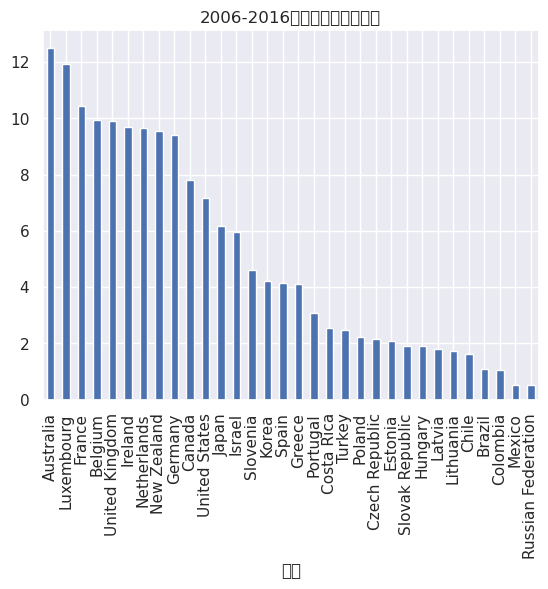

In [28]:
merged.mean().sort_values(ascending=False).plot(kind='bar',
                                                title="2006-2016年平均实际最低工资")

# 设置国家标签
country_labels = merged.mean().sort_values(ascending=False).index.get_level_values('Country').tolist()
plt.xticks(range(0, len(country_labels)), country_labels)
plt.xlabel('国家')

plt.show()

通过向`.mean()`传入`axis=1`参数可以对列进行聚合（得到所有国家随时间变化的平均最低工资）

In [29]:
merged.mean(axis=1).head()

Time
2006-01-01   4.69
2007-01-01   4.84
2008-01-01   4.90
2009-01-01   5.08
2010-01-01   5.11
dtype: float64

我们可以将这个时间序列绘制成折线图

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

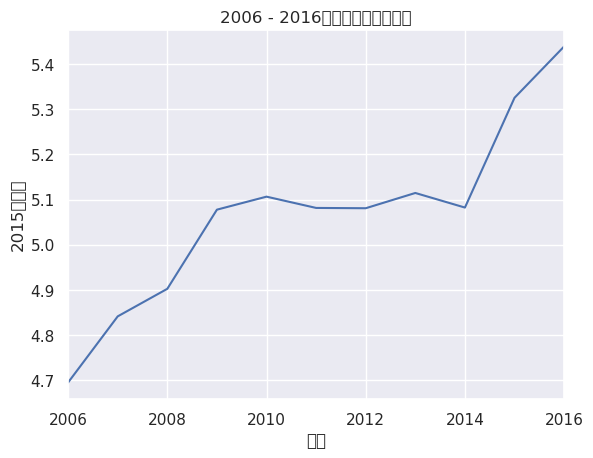

In [30]:
merged.mean(axis=1).plot()
plt.title('2006 - 2016年平均实际最低工资')
plt.ylabel('2015年美元')
plt.xlabel('年份')
plt.show()

我们也可以指定`MultiIndex`的一个层级（在列轴上）来进行聚合

In [31]:
merged.groupby(level='Continent', axis=1).mean().head()

/tmp/ipykernel_7572/646686994.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged.groupby(level='Continent', axis=1).mean().head()


Continent,America,Asia,Australia,Europe
Time,,,,
2006-01-01,2.80,4.29,10.25,4.80
2007-01-01,2.85,4.44,10.73,4.94
2008-01-01,2.99,4.45,10.76,4.99
2009-01-01,3.23,4.53,10.97,5.16
2010-01-01,3.34,4.53,10.95,5.17


我们可以将每个大洲的平均最低工资绘制成时间序列图

/tmp/ipykernel_7572/1721731087.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged.groupby(level='Continent', axis=1).mean().plot()
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

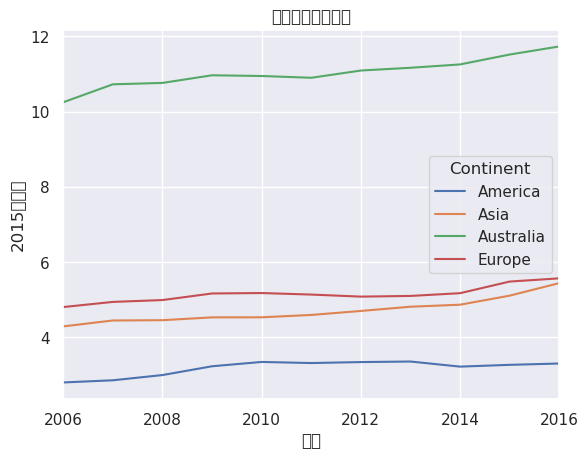

In [32]:
merged.groupby(level='Continent', axis=1).mean().plot()
plt.title('平均实际最低工资')
plt.ylabel('2015年美元')
plt.xlabel('年份')
plt.show()

为了绘图目的，我们将去掉澳大利亚这个大洲

/tmp/ipykernel_7572/3197233217.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged.groupby(level='Continent', axis=1).mean().plot()
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

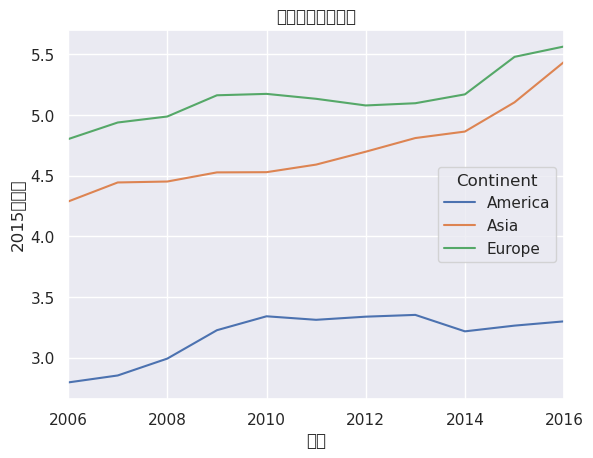

In [33]:
merged = merged.drop('Australia', level='Continent', axis=1)
merged.groupby(level='Continent', axis=1).mean().plot()
plt.title('平均实际最低工资')
plt.ylabel('2015年美元')
plt.xlabel('年份')
plt.show()

`.describe()` 可以快速获取一些常见的统计摘要数据

In [34]:
merged.stack().describe()

/tmp/ipykernel_7572/4288984536.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  merged.stack().describe()


Continent,America,Asia,Europe
count,69.00,44.00,200.00
mean,3.19,4.70,5.15
std,3.02,1.56,3.82
min,0.52,2.22,0.23
25%,1.03,3.37,2.02
50%,1.44,5.48,3.54
75%,6.96,5.95,9.70
max,8.48,6.65,12.39


这是使用 `groupby` 的简化方法。

使用 `groupby` 通常遵循"拆分-应用-合并"的过程：

* 拆分：数据根据一个或多个键进行分组
* 应用：在每个组上独立调用函数
* 合并：函数调用的结果被合并到新的数据结构中

`groupby` 方法实现了这个过程的第一步，创建一个新的 `DataFrameGroupBy` 对象，将数据拆分成组。

让我们再次按大洲拆分 `merged`，这次使用 `groupby` 函数，并将结果对象命名为 `grouped`

In [35]:
grouped = merged.groupby(level='Continent', axis=1)
grouped

/tmp/ipykernel_7572/920372348.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = merged.groupby(level='Continent', axis=1)


在对象上调用聚合方法会将函数应用于每个组，其结果会被合并到一个新的数据结构中。

例如，我们可以使用`.size()`返回数据集中每个大洲的国家数量。

在这种情况下，我们的新数据结构是一个`Series`

In [36]:
grouped.size()

Continent
America     7
Asia        4
Europe     19
dtype: int64

通过调用 `.get_group()` 来返回单个组中的国家，我们可以为每个大洲创建2016年实际最低工资分布的核密度估计。

`grouped.groups.keys()` 将返回 `groupby` 对象中的键

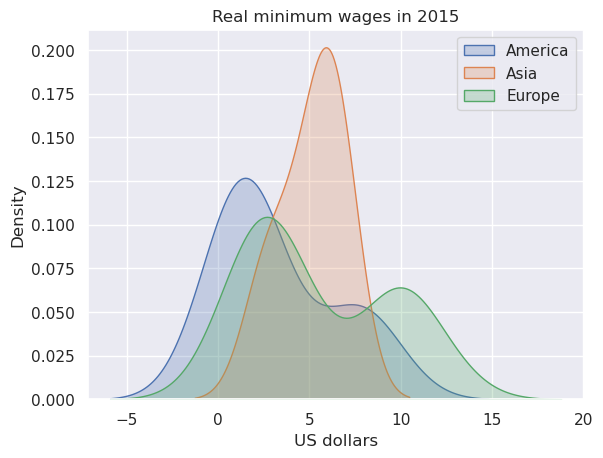

In [37]:
continents = grouped.groups.keys()

for continent in continents:
    sns.kdeplot(grouped.get_group(continent).loc['2015'].unstack(), label=continent, fill=True)

plt.title('Real minimum wages in 2015')
plt.xlabel('US dollars')
plt.legend()
plt.show()

## 总结

本讲座介绍了pandas的一些高级特性，包括多重索引、合并、分组和绘图。

在面板数据分析中可能有用的其他工具包括[xarray](https://docs.xarray.dev/en/stable/)，这是一个将pandas扩展到N维数据结构的Python包。

## 练习

```{exercise-start}
:label: pp_ex1
```

在这些练习中，你将使用来自[Eurostat](https://ec.europa.eu/eurostat/data/database)的欧洲按年龄和性别划分的就业率数据集。

可以通过以下链接访问数据集：

In [38]:
url3 = 'https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/employ.csv'

读取 CSV 文件会返回一个长格式的面板数据集。使用 `.pivot_table()` 构建一个带有 `MultiIndex` 列的宽格式数据框。

首先探索数据框和 `MultiIndex` 层级中可用的变量。

编写一个程序，快速返回 `MultiIndex` 中的所有值。

```{exercise-end}
```

```{solution-start} pp_ex1
:class: dropdown
```

In [39]:
employ = pd.read_csv(url3)
employ = employ.pivot_table(values='Value',
                            index=['DATE'],
                            columns=['UNIT','AGE', 'SEX', 'INDIC_EM', 'GEO'])
employ.index = pd.to_datetime(employ.index) # 确保日期为 datetime 格式
employ.head()

UNIT       Percentage of total population                   ...  \
AGE                   From 15 to 24 years                   ...   
SEX                               Females                   ...   
INDIC_EM                Active population                   ...   
GEO                               Austria Belgium Bulgaria  ...   
DATE                                                        ...   
2007-01-01                          56.00   31.60    26.00  ...   
2008-01-01                          56.20   30.80    26.10  ...   
2009-01-01                          56.20   29.90    24.80  ...   
2010-01-01                          54.00   29.80    26.60  ...   
2011-01-01                          54.80   29.80    24.80  ...   

UNIT                                           Thousand persons           \
AGE                                         From 55 to 64 years            
SEX                                                       Total            
INDIC_EM   Total employment (resident population concept - LFS)            
GEO                                                 Switzerland   Turkey   
DATE                                                                       
2007-01-01                                                NaN   1,282.00   
2008-01-01                                                NaN   1,354.00   
2009-01-01                                                NaN   1,449.00   
2010-01-01                                             640.00   1,583.00   
2011-01-01                                             661.00   1,760.00   

UNIT                       
AGE                        
SEX                        
INDIC_EM                   
GEO        United Kingdom  
DATE                       
2007-01-01       4,131.00  
2008-01-01       4,204.00  
2009-01-01       4,193.00  
2010-01-01       4,186.00  
2011-01-01       4,164.00  

[5 rows x 1440 columns]

由于这是一个大型数据集，因此探索可用的层级和变量很有用

In [40]:
employ.columns.names

FrozenList(['UNIT', 'AGE', 'SEX', 'INDIC_EM', 'GEO'])

可以通过循环快速获取层级中的变量

In [41]:
for name in employ.columns.names:
    print(name, employ.columns.get_level_values(name).unique())

UNIT Index(['Percentage of total population', 'Thousand persons'], dtype='object', name='UNIT')
AGE Index(['From 15 to 24 years', 'From 25 to 54 years', 'From 55 to 64 years'], dtype='object', name='AGE')
SEX Index(['Females', 'Males', 'Total'], dtype='object', name='SEX')
INDIC_EM Index(['Active population', 'Total employment (resident population concept - LFS)'], dtype='object', name='INDIC_EM')
GEO Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Euro area (17 countries)',
       'Euro area (18 countries)', 'Euro area (19 countries)',
       'European Union (15 countries)', 'European Union (27 countries)',
       'European Union (28 countries)', 'Finland',
       'Former Yugoslav Republic of Macedonia, the', 'France',
       'France (metropolitan)',
       'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Neth

```{solution-end}
```

```{exercise-start}
:label: pp_ex2
```

筛选上述数据框，仅包含以'活动人口'百分比表示的就业数据。

使用`seaborn`创建一个按年龄组和性别分组的2015年就业率箱线图。

```{hint}
:class: dropdown

`GEO`包含地区和国家。
```

```{exercise-end}
```

```{solution-start} pp_ex2
:class: dropdown
```

为了方便按国家筛选，将`GEO`调整到最上层并对`MultiIndex`进行排序

In [42]:
employ.columns = employ.columns.swaplevel(0,-1)
employ = employ.sort_index(axis=1)

我们需要删除`GEO`中一些不是国家的项目。

一个快速去除欧盟地区的方法是使用列表推导式来查找`GEO`中以'Euro'开头的层级值。

In [43]:
geo_list = employ.columns.get_level_values('GEO').unique().tolist()
countries = [x for x in geo_list if not x.startswith('Euro')]
employ = employ[countries]
employ.columns.get_level_values('GEO').unique()

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland',
       'Former Yugoslav Republic of Macedonia, the', 'France',
       'France (metropolitan)',
       'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom'],
      dtype='object', name='GEO')

从数据框中仅选择活动人口中的就业百分比

In [44]:
employ_f = employ.xs(('Percentage of total population', 'Active population'),
                     level=('UNIT', 'INDIC_EM'),
                     axis=1)
employ_f.head()

GEO                    Austria              ...      United Kingdom        \
AGE        From 15 to 24 years              ... From 55 to 64 years         
SEX                    Females Males Total  ...             Females Males   
DATE                                        ...                             
2007-01-01               56.00 62.90 59.40  ...               49.90 68.90   
2008-01-01               56.20 62.90 59.50  ...               50.20 69.80   
2009-01-01               56.20 62.90 59.50  ...               50.60 70.30   
2010-01-01               54.00 62.60 58.30  ...               51.10 69.20   
2011-01-01               54.80 63.60 59.20  ...               51.30 68.40   

GEO               
AGE               
SEX        Total  
DATE              
2007-01-01 59.30  
2008-01-01 59.80  
2009-01-01 60.30  
2010-01-01 60.00  
2011-01-01 59.70  

[5 rows x 306 columns]

在创建分组箱形图之前删除"总计"值

In [45]:
employ_f = employ_f.drop('Total', level='SEX', axis=1)

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

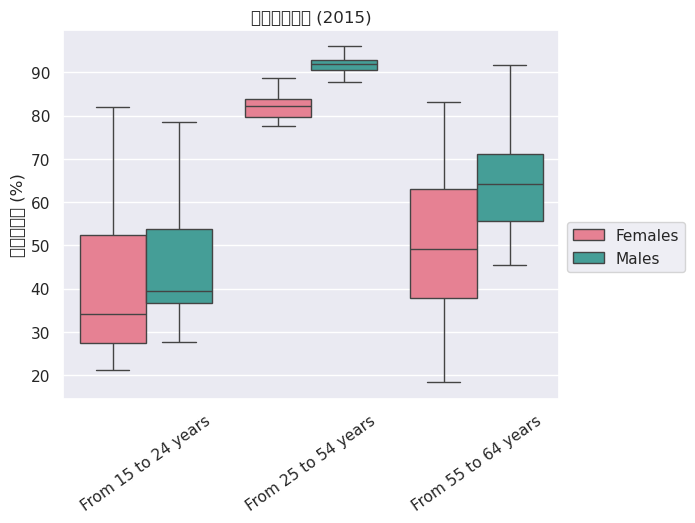

In [46]:
box = employ_f.loc['2015'].unstack().reset_index()
sns.boxplot(x="AGE", y=0, hue="SEX", data=box, palette=("husl"), showfliers=False)
plt.xlabel('')
plt.xticks(rotation=35)
plt.ylabel('人口百分比 (%)')
plt.title('欧洲就业情况 (2015)')
plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

```{solution-end}
```